In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline

#import wisps
import astropy.units as u
from astropy.coordinates import SkyCoord

import wisps
import wisps.simulations as wispsim

In [2]:
#pm.__version__

In [3]:
h=300
Rsun=83000.
Zsun=27.

In [16]:
def density_function(r, z, h=300.):
    
    """
    A custom density 
    """
    l = 2600.
    zpart=np.exp(-abs(z-27)/h)
    rpart=np.exp(-(r-8300)/l)
    return zpart*rpart

def logp(l, b, r, z, d, h):
    return np.log((d**2)*density_function(r, z, h))


def draw_with_pymc(l, b, dmax, nsample):
    
    with pm.Model() as model:
        d=pm.Uniform('d', lower=0., upper=dmax, testval=dmax/10.)
        
        x=pm.Deterministic('x',  Rsun-d*np.cos(b)*np.cos(l))
        y=pm.Deterministic('y', -d*np.cos(b)*np.sin(l))
        r=pm.Deterministic('r', (x**2+y**2)**0.5 )
        z=pm.Deterministic('z', Zsun+ d * np.sin(b))
        
        like = pm.Potential('likelihood', logp(l, b, r, z, d, h))

        trace = pm.sample(draws=int(nsample), cores=4, tune=int(nsample/20),
            discard_tuned_samples=True, step=pm.Metropolis())
        
    return trace

def draw_with_cdf(l, b, dmax, nsample):
    d=np.logspace(0, np.log10(dmax), int(nsample))
    cdfvals=np.array([wispsim.custom_volume(l,b,0, dx, h) for dx in d])
    return wisps.random_draw(d, cdfvals/np.nanmax(cdfvals), nsample)


In [5]:
from itertools import combinations, product≠

In [15]:
l_values=[0, np.pi/2, np.pi, 1.5*np.pi, 2*np.pi  ]
b_values=[0, np.pi/2, np.pi]
d_values=[20, 100, 500, 1000, 3000]
s=[l_values, b_values, d_values]
nsample=int(1e3)
VALS={}
for l, b, dmax in list(product(*s)):
    pym_draws=draw_with_pymc(l, b, dmax, nsample)
    cdf_draws=(draw_with_cdf(l, b, dmax, nsample)['d']).flatten()
    
    VALS.update({'l (deg) {} b (de) {} d {} '.format(np.round(l*u.radian.to(u.degree)),
                                                      np.round(b*u.radian.to(u.degree)), dmax): 
                 {'cdf': cdf_draws, 'pymc': pym_draws}})
    

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 40 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 33 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 35 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 30 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 23 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 34 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 19 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 26 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 26 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 55 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 44 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 30 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 32 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 23 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 28 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 33 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 42 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 32 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.


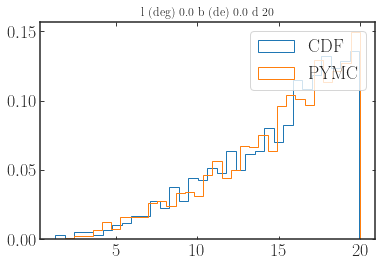

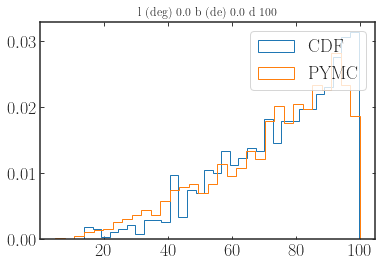

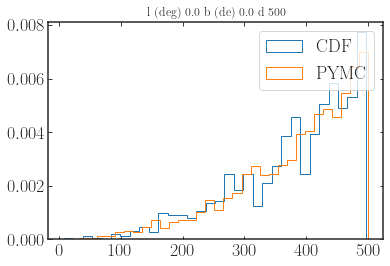

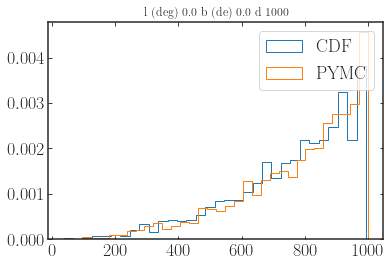

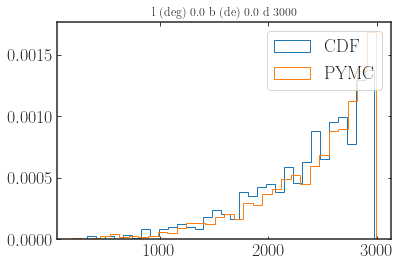

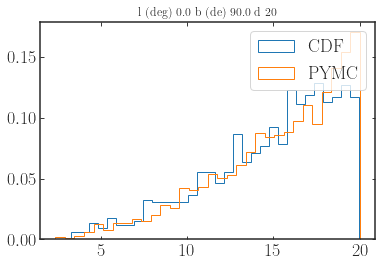

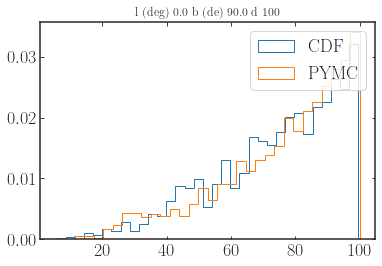

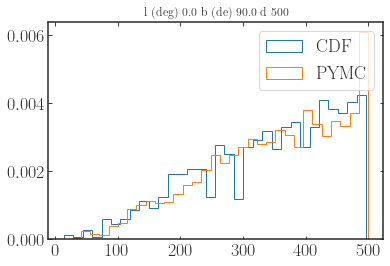

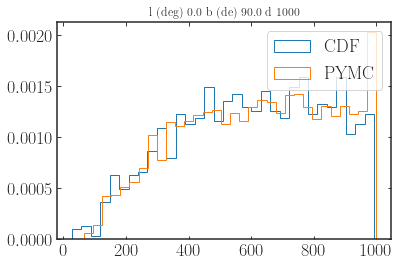

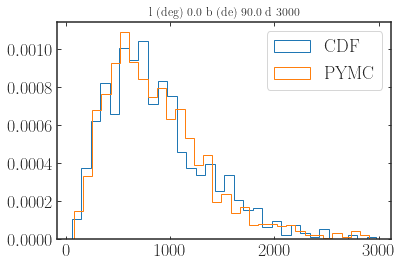

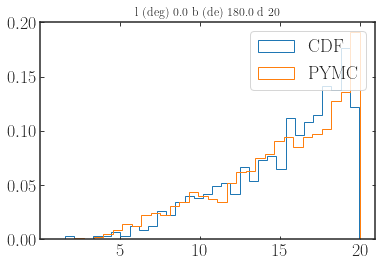

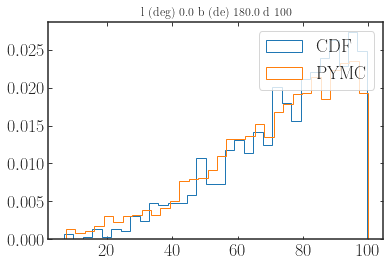

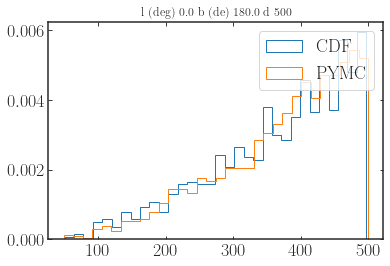

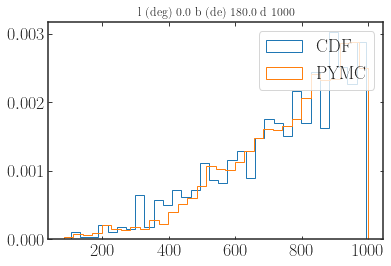

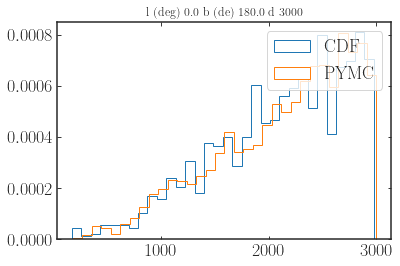

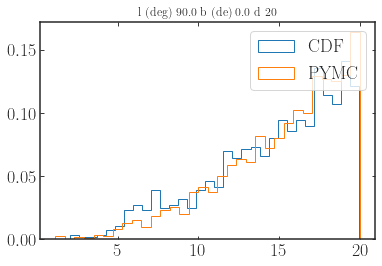

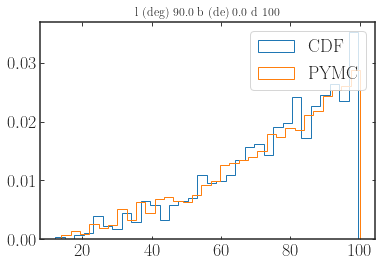

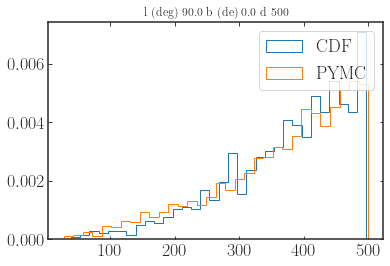

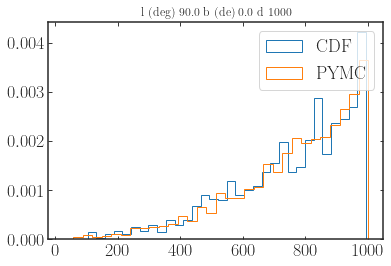

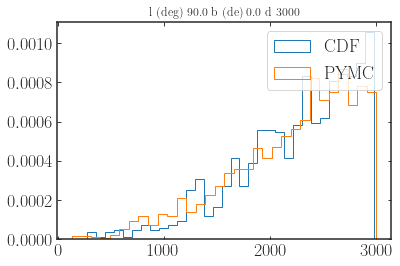

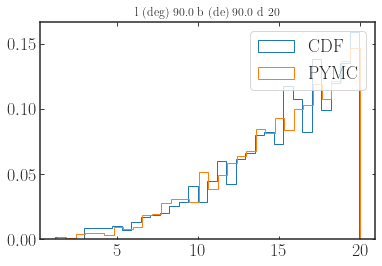

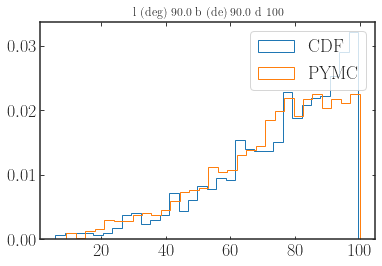

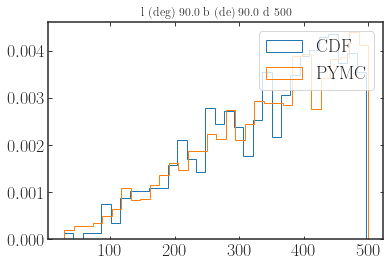

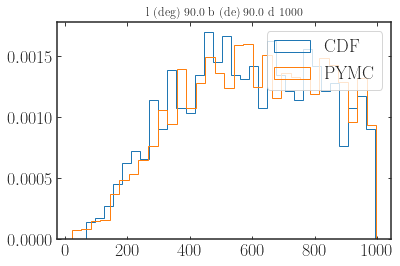

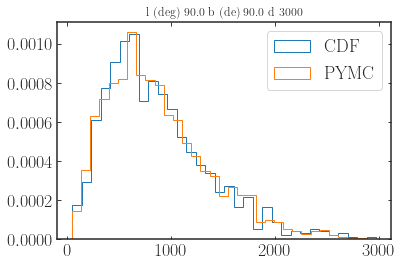

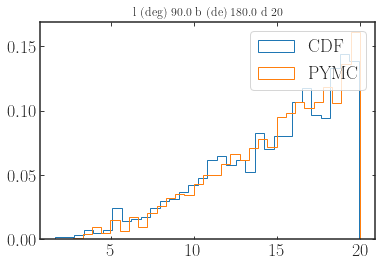

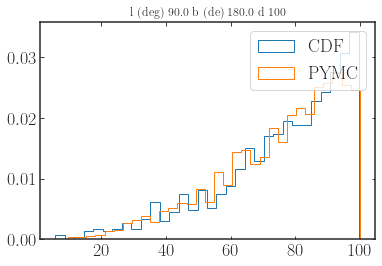

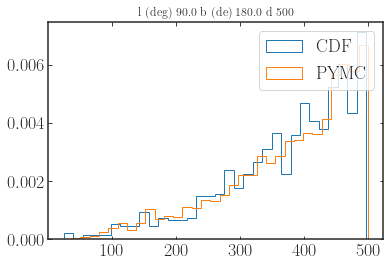

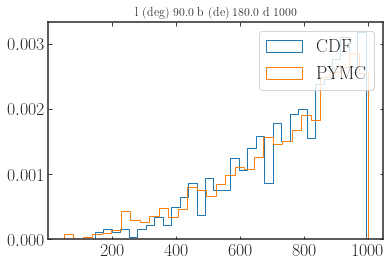

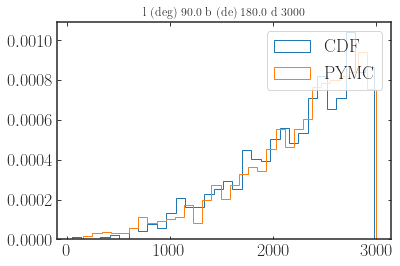

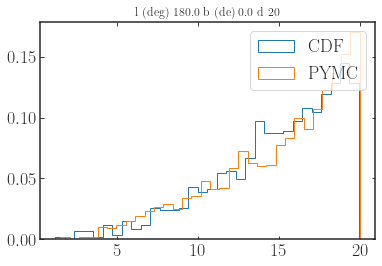

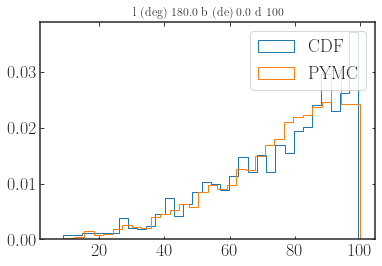

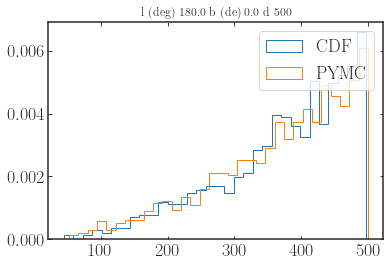

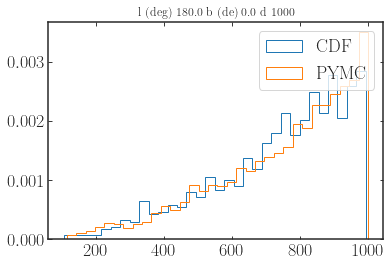

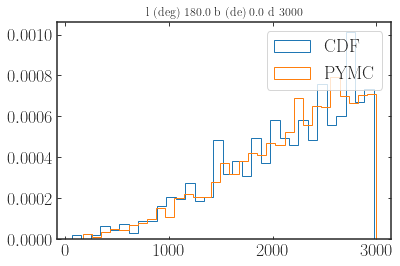

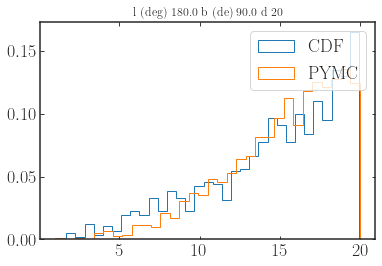

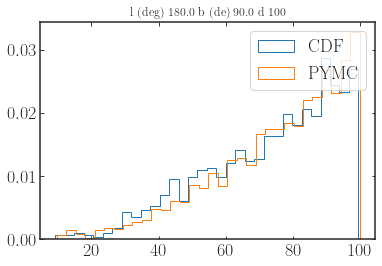

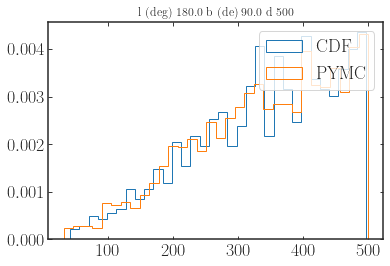

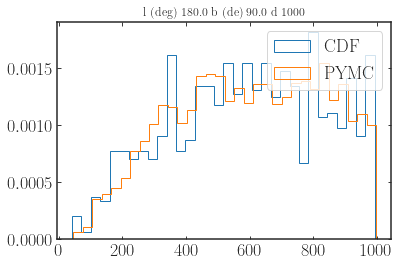

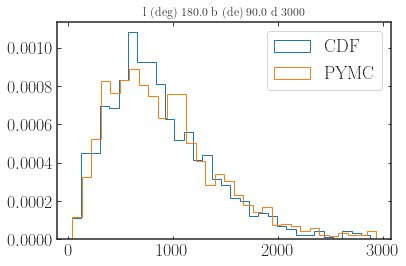

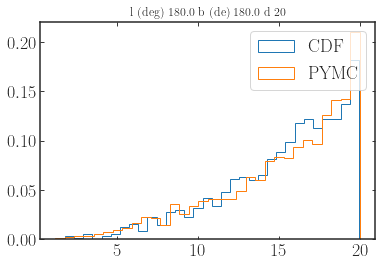

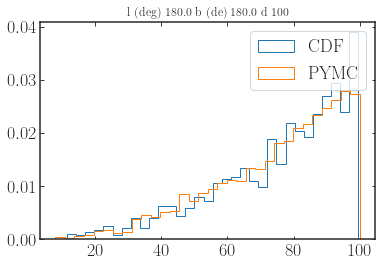

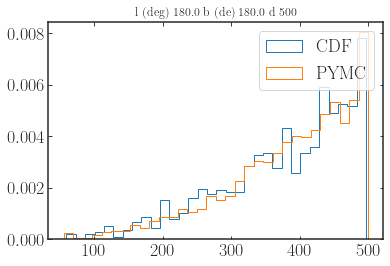

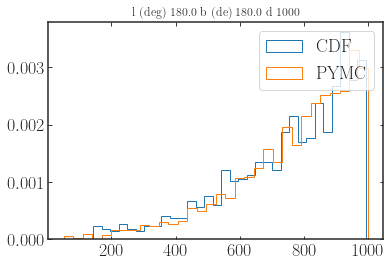

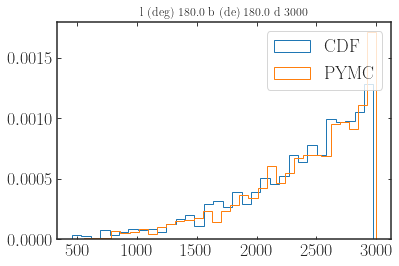

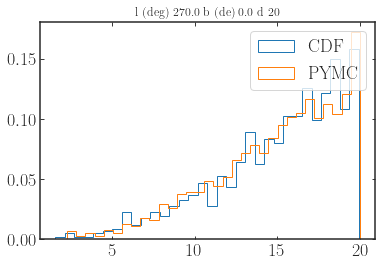

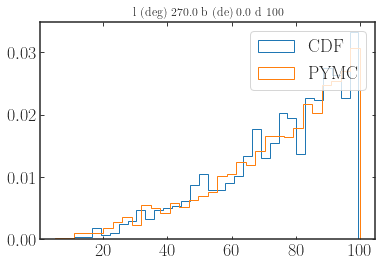

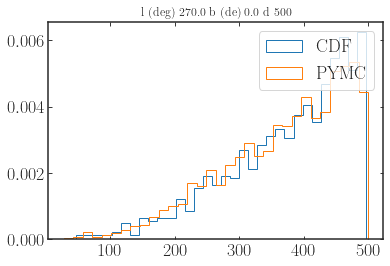

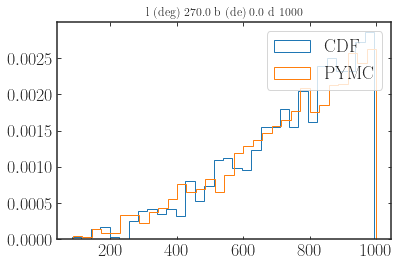

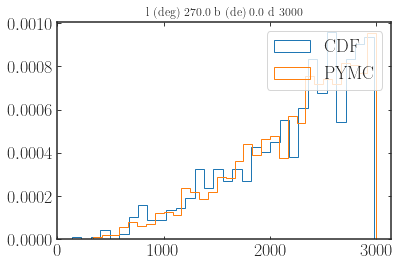

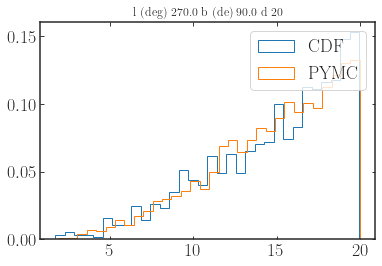

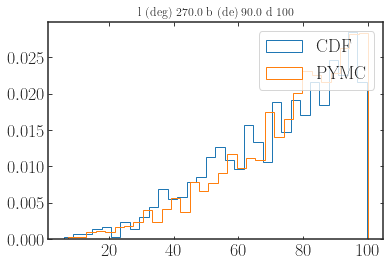

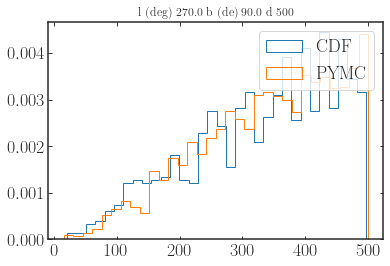

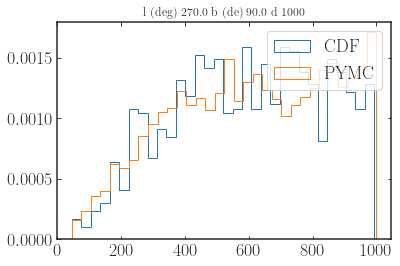

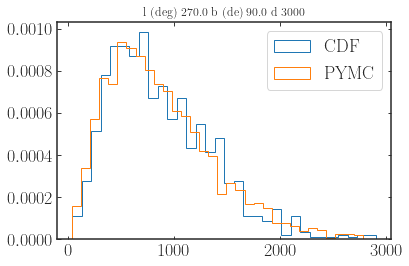

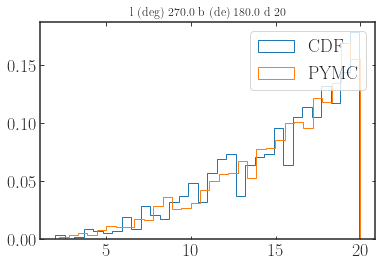

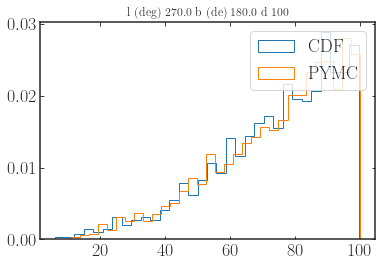

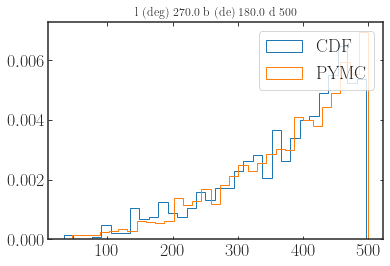

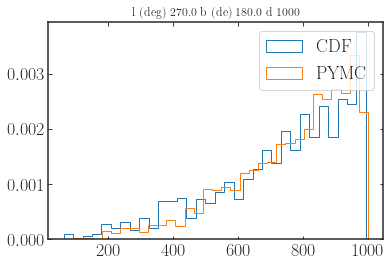

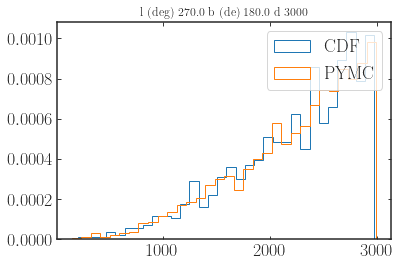

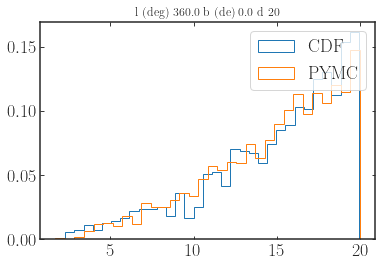

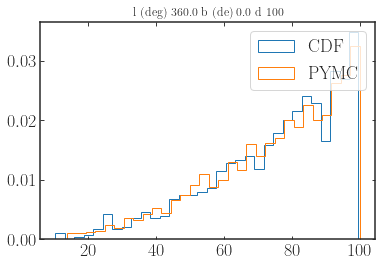

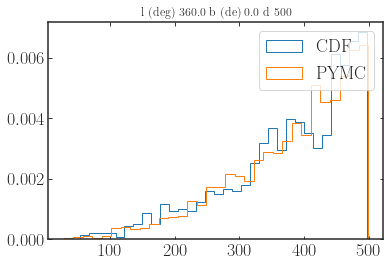

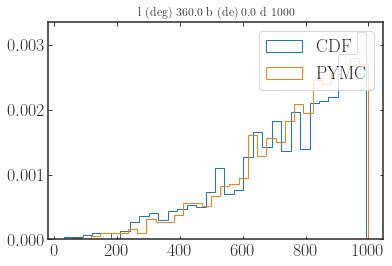

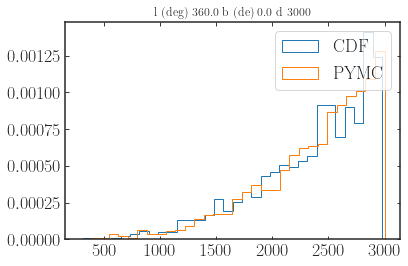

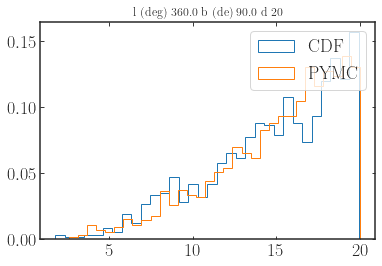

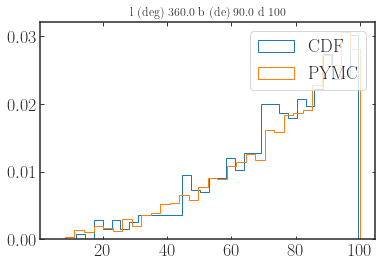

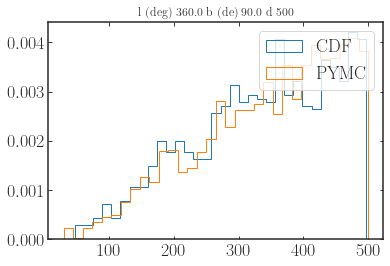

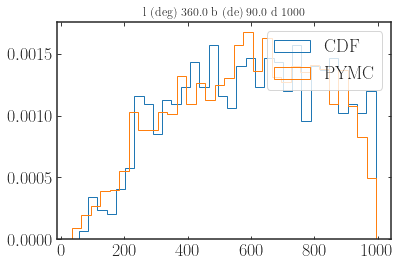

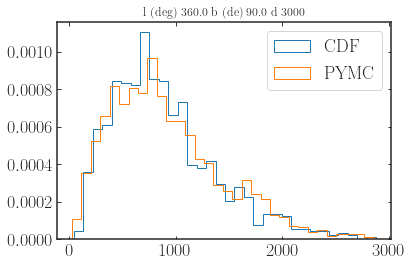

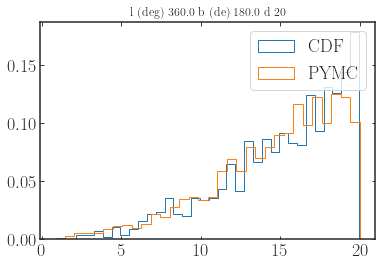

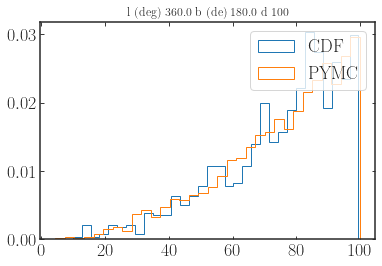

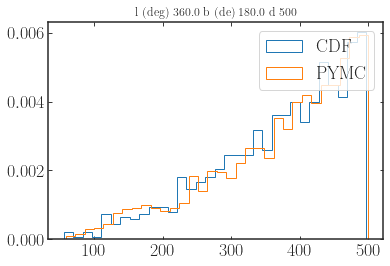

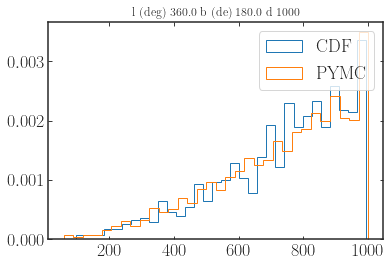

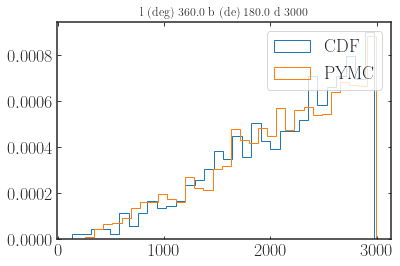

In [13]:
%matplotlib inline
for k in VALS.keys():
    fig, ax=plt.subplots()
    plt.hist(VALS[k]['cdf'], bins=32, histtype='step', label='CDF', density=True)
    plt.hist(VALS[k]['pymc'], bins=32,histtype='step', label='PYMC',density=True)
    plt.title(k)
    plt.legend()
    plt.show()

In [14]:
#pm.model_graph.model_to_graphviz(model)